In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from mpl_toolkits.mplot3d import Axes3D

# Loading Data

In [2]:
structure_names = ["Ge-1_Se-1", "Ge-1_Te-1"]

In [3]:
df = pd.concat([pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "data/" + struct_name + ".csv"), index_col=0) for struct_name in structure_names])

In [4]:
cols_raw = list(df.columns)
cols_trash = ['converged', 'accuracy']
cols_independent = ['delta_E']
cols_drop = cols_trash + cols_independent

cols_dependent = cols_raw.copy()
for element in cols_drop:
    cols_dependent.remove(element)

In [5]:
X_raw = df[cols_dependent]
y_raw = df[cols_independent]

In [6]:
X_raw.describe()

,ecutrho,k_density,ecutwfc,total_energy,Ag,Al,Ar,As,Au,B,...,Ti,Tl,Tm,V,W,Xe,Y,Yb,Zn,Zr
count,1235.000000,1235.000000,1235.000000,1235.000000,1235.0,1235.0,1235.0,1235.0,1235.0,1235.0,...,1235.0,1235.0,1235.0,1235.0,1235.0,1235.0,1235.0,1235.0,1235.0,1235.0
mean,242.348178,0.228981,56.558704,-248.592989,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,90.009860,0.145444,22.897391,8.432126,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,100.000000,0.100000,20.000000,-256.544200,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,180.000000,0.125000,35.000000,-256.528234,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,260.000000,0.166667,55.000000,-256.231892,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,340.000000,0.250000,75.000000,-239.640097,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,380.000000,0.500000,100.000000,-238.770810,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
y_raw[X_raw["Se"] > 0.0].describe()

,delta_E
count,661.000000
mean,0.083367
std,0.188367
min,-0.015443
25%,0.000075
50%,0.000610
75%,0.128333
max,0.886049


In [8]:
y_raw[X_raw["Te"] > 0.0].describe()

,delta_E
count,574.000000
mean,0.091804
std,0.198588
min,-0.013121
25%,0.001786
50%,0.002189
75%,0.132751
max,0.871409


# Train-Test-Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw,
    test_size=0.1,
    random_state=42)

# Pipeline Definition

## Linear Model with polynomial feature augmentation

In [10]:
def exp_decay(x, lambda_):
    return np.exp(-lambda_*x)

In [11]:
#DEFINITION OF PREPROCESSING STEPS
scaler = StandardScaler()
poly_augmentation = PolynomialFeatures(degree=2)

lambda_ = 1
exp_decay_augmentation = FunctionTransformer(lambda x : exp_decay(x, lambda_))

In [12]:
#DEFINITION OF REGRESSOR
linear_regressor = LinearRegression()
#regressor = GradientBoostingRegressor

In [13]:
#COMBINING EVERYTHING TO A PIPELINE
simple_model = Pipeline([
    ('poly', poly_augmentation),
    #('exp_decay', exp_decay_augmentation),
    ('scaler', scaler),
    ('regressor', linear_regressor)
])

In [14]:
simple_model.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures()), ('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [15]:
mse_test = mean_squared_error(y_test, simple_model.predict(X_test))
mse_train = mean_squared_error(y_train, simple_model.predict(X_train))
print(f"MSE:\ttrain:{mse_train}\ttest:{mse_test}")

MSE:	train:7.982419882931707e-29	test:8.982199814076387e-29


In [16]:
mape_test = mean_absolute_percentage_error(y_test, simple_model.predict(X_test))
mape_train = mean_absolute_percentage_error(y_train, simple_model.predict(X_train))
print(f"MAPE:\ttrain:{mape_train}\ttest:{mape_test}")

MAPE:	train:0.0204770478257871	test:1.002079464841451e-11


## Random Forest

In [17]:
rf_regressor = RandomForestRegressor()
rf_model = rf_regressor
# rf_model = Pipeline([
#     ('poly', poly_augmentation),
#     ('scaler', scaler),
#     ('regressor', rf_regressor)
# ])

In [18]:
rf_model.fit(X_train, y_train)

<ipython-input-18-ce45b449cc1f>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


RandomForestRegressor()

In [19]:
mse_test = mean_squared_error(y_test, rf_model.predict(X_test))
mse_train = mean_squared_error(y_train, rf_model.predict(X_train))
print(f"MSE:\ttrain:{mse_train}\ttest:{mse_test}")

MSE:	train:9.656456605744481e-08	test:1.8769880009386786e-06


In [20]:
mape_test = mean_absolute_percentage_error(y_test, rf_model.predict(X_test))
mape_train = mean_absolute_percentage_error(y_train, rf_model.predict(X_train))
print(f"MAPE:\ttrain:{mape_train}\ttest:{mape_test}")

MAPE:	train:1496605.798215205	test:0.015702828391794092


# Visualization

In [21]:
import matplotlib.pyplot as plt

(2, 3)


Text(0.5, 0, 'ecutwfc')

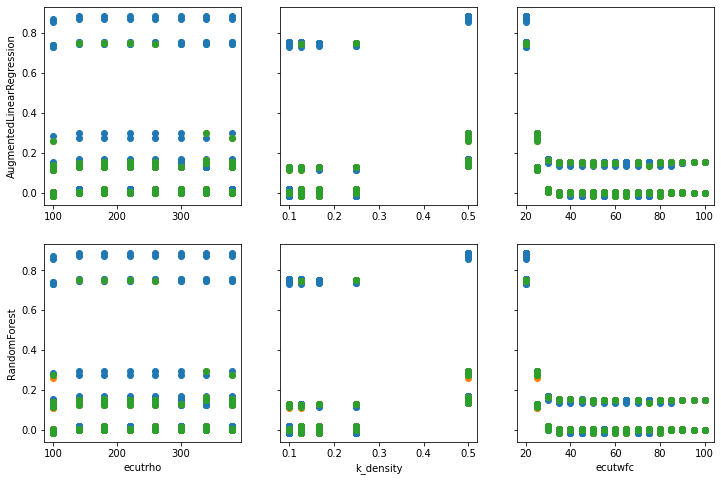

In [22]:
models = {"AugmentedLinearRegression": simple_model, "RandomForest": rf_model}
n_models = len(models)
fig, ax = plt.subplots(n_models,3,figsize=(12,4*n_models), sharey=True, squeeze=False)
print(ax.shape)
for j, (name, model) in enumerate(models.items()):
    for i, col in enumerate(X_train.columns[:3]):
        ax[j,i].scatter(X_train[col], y_train)
        ax[j,i].scatter(X_test[col], y_test)
        ax[j,i].scatter(X_test[col], model.predict(X_test))
    ax[j,0].set_ylabel(name)
ax[-1,0].set_xlabel("ecutrho")
ax[-1,1].set_xlabel('k_density')
ax[-1,2].set_xlabel('ecutwfc')
# PLOTPATH = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "plots/simple_regression/toy_comparison.png")
# plt.savefig(PLOTPATH)

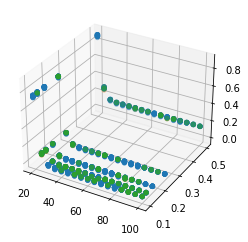

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train['ecutwfc'], X_train['k_density'], y_train)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], y_test)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], rf_model.predict(X_test))